Using 1244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy: 1.0
              precision    recall  f1-score   support

   excellent       1.00      1.00      1.00       293
        good       1.00      1.00      1.00        23

    accuracy                           1.00       316
   macro avg       1.00      1.00      1.00       316
weighted avg       1.00      1.00      1.00       316



  0%|          | 0/316 [00:00<?, ?it/s]

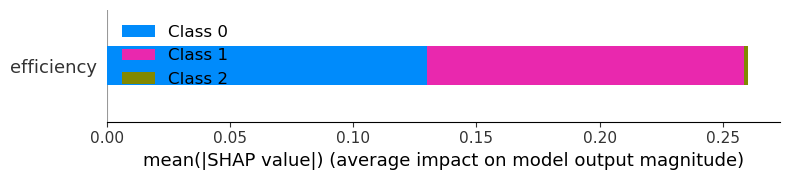

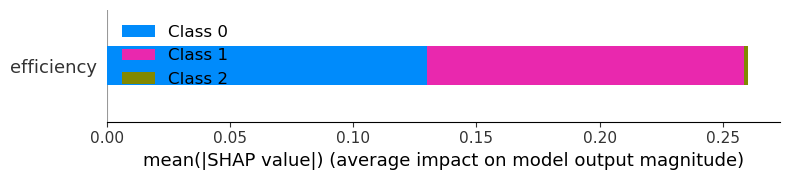

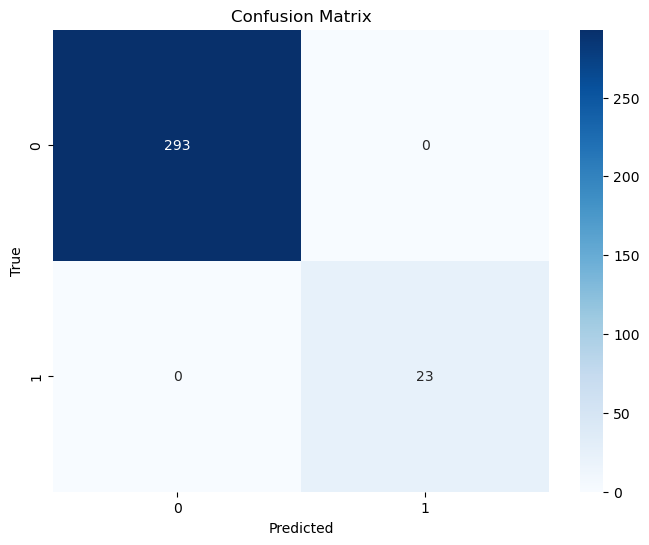

In [1]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Define a function to load participant data from the overview Excel file
def load_participant_data(path):
    return pd.read_excel(os.path.join(path, 'participant-overview.xlsx'))

def load_bpm_data(participant, path):
    file_path = os.path.join(path, f'P{participant:02d}/fitbit/heart_rate.json')
    return pd.read_json(file_path)

def load_calories_data(participant, path):
    file_path = os.path.join(path, f'P{participant:02d}/fitbit/calories.json')
    return pd.read_json(file_path)

def load_exercise_data(participant, path):
    file_path = os.path.join(path, f'P{participant:02d}/fitbit/exercise.json')
    return pd.read_json(file_path)

def load_sleep_data(participant, path):
    file_path = os.path.join(path, f'P{participant:02d}/fitbit/sleep.json')
    return pd.read_json(file_path)

def load_steps_data(participant, path):
    file_path = os.path.join(path, f'P{participant:02d}/fitbit/steps.json')
    return pd.read_json(file_path)

def load_distance_data(participant, path):
    file_path = os.path.join(path, f'P{participant:02d}/fitbit/distance.json')
    return pd.read_json(file_path)

def load_day_data(participant, path):
    day_data = {}
    day_files = [
        'lightly_active_minutes.json',
        'moderately_active_minutes.json',
        'resting_heart_rate.json',
        'sedentary_minutes.json',
        'time_in_heart_rate_zones.json',
        'very_active_minutes.json'
    ]
    for file in day_files:
        key = file.split(".")[0]
        file_path = os.path.join(path, f'P{participant:02d}/fitbit', file)
        day_data[key] = pd.read_json(file_path)
    return day_data

# Conversion of sleep score to classes
def convert_sleep_score(score):
    if 90 <= score <= 100:
        return "excellent"
    elif 80 <= score <= 89:
        return "good"
    elif 60 <= score <= 69:
        return "fair"
    else:
        return "poor"

# Combine loading functions into one function for ease of use
def load_fitbit_data(participants, path):
    data = {}
    for participant in participants:
        participant_data = load_participant_data(path)
        data[f'Participant_{participant}'] = participant_data
        data[f'BPM_{participant}'] = load_bpm_data(participant, path)
        data[f'Calories_{participant}'] = load_calories_data(participant, path)
        data[f'Exercise_{participant}'] = load_exercise_data(participant, path)
        data[f'Sleep_{participant}'] = load_sleep_data(participant, path)
        data[f'Steps_{participant}'] = load_steps_data(participant, path)
        data[f'Distance_{participant}'] = load_distance_data(participant, path)
        day_data = load_day_data(participant, path)
        data[f'Day_{participant}'] = day_data

    return data
# Splitting data and fitting the Logistic Regression classifier

def sleep_score_processing(samples):
    if 'efficiency' in samples:
        samples['Sleep_Score_Class'] = samples['efficiency'].apply(convert_sleep_score)
    return samples

def perform_data_processing(loaded_data):
    processed_data = {}
    for participant, data in loaded_data.items():
        processed_data[participant] = sleep_score_processing(data)
    return processed_data

def run_fitting_classifiers(processed_data, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = [], [], [], []
    for participant, data in processed_data.items():
        if 'efficiency' in data:
            X = data['efficiency'].values.reshape(-1, 1)
            y = data['Sleep_Score_Class']
            X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X, y, test_size=test_size, random_state=random_state)
            X_train.append(pd.DataFrame(X_train_part, columns=['efficiency']))  # Convert to DataFrame
            X_test.append(pd.DataFrame(X_test_part, columns=['efficiency']))  # Convert to DataFrame
            y_train.append(y_train_part)
            y_test.append(y_test_part)

    X_train = pd.concat(X_train)
    X_test = pd.concat(X_test)
    y_train = pd.concat(y_train)
    y_test = pd.concat(y_test)

    #  Logistic Regression Classifier
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)  # Fit on the training data

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(report)
    return classifier, X_train, X_test, y_test  # Return y_test along with other variables

def plot_feature_importance(shap_values, features):
    shap.summary_plot(shap_values, features)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
participants_list = [1,2,3,4,5,6,7,8,9,10,11]
data_path = r'C:\Users\91734\Desktop\BDSS_Final\pmdata'# dataset path
prediction_time = 12
observation_window = 4
test_size = 0.2

loaded_data = load_fitbit_data(participants_list, data_path)

#  data processing for Sleep Score
processed_data = perform_data_processing(loaded_data)

# Train-test split 
classifier, X_train, X_test, y_test = run_fitting_classifiers(processed_data, test_size=test_size)

#  SHAP explainer for the Logistic Regression classifier using KernelExplainer
explainer = shap.KernelExplainer(model=classifier.predict_proba, data=X_train)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)

# Plot feature importance
plot_feature_importance(shap_values, X_test)

# Plot confusion matrix
y_pred = classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred)


Accuracy: 0.9967948717948718
              precision    recall  f1-score   support

   excellent       0.99      1.00      0.99        88
        fair       1.00      1.00      1.00         8
        good       1.00      1.00      1.00       216

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312



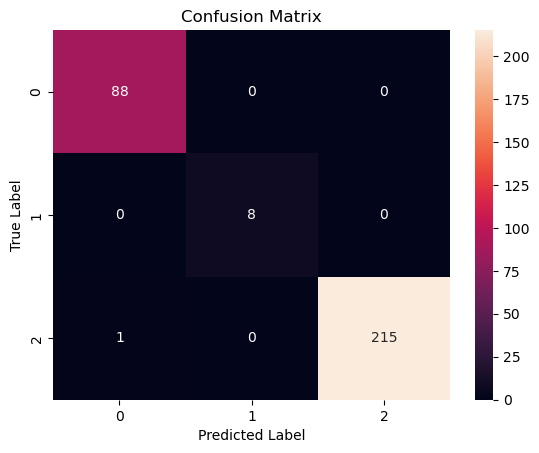

Using 1248 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/312 [00:00<?, ?it/s]

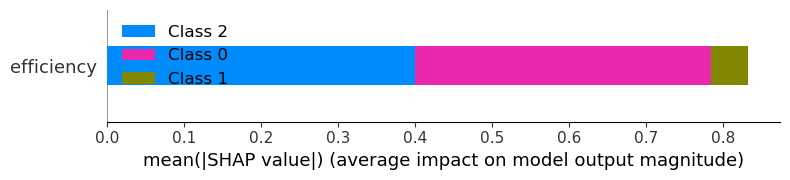

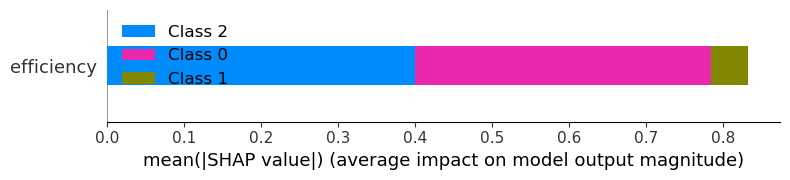

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Define data loading functions
def load_participant_data(path):
    return pd.read_excel(os.path.join(path, 'participant-overview.xlsx'))

def load_bpm_data(participant, path):
    return pd.read_json(os.path.join(path, f'P{participant:02d}/fitbit/heart_rate.json'))

def load_calories_data(participant, path):
    return pd.read_json(os.path.join(path, f'P{participant:02d}/fitbit/calories.json'))

def load_exercise_data(participant, path):
    return pd.read_json(os.path.join(path, f'P{participant:02d}/fitbit/exercise.json'))

def load_sleep_data(participant, path):
    return pd.read_json(os.path.join(path, f'P{participant:02d}/fitbit/sleep.json'))

def load_steps_data(participant, path):
    return pd.read_json(os.path.join(path, f'P{participant:02d}/fitbit/steps.json'))

def load_distance_data(participant, path):
    return pd.read_json(os.path.join(path, f'P{participant:02d}/fitbit/distance.json'))


def load_day_data(participant, path):
    day_data = {}
    day_files = [
        'lightly_active_minutes.json',
        'moderately_active_minutes.json',
        'resting_heart_rate.json',
        'sedentary_minutes.json',
        'time_in_heart_rate_zones.json',
        'very_active_minutes.json'
    ]
    for file_name in day_files:
        file_path = os.path.join(path, f'P{participant:02d}/fitbit', file_name)
        key = file_name.split(".")[0]
        day_data[key] = pd.read_json(file_path)
    return day_data

def load_fitbit_data(participants, path):
    data = {}
    for participant in participants:
        data[f'Participant_{participant}'] = load_participant_data(path)
        data[f'BPM_{participant}'] = load_bpm_data(participant, path)
        data[f'Calories_{participant}'] = load_calories_data(participant, path)
        data[f'Exercise_{participant}'] = load_exercise_data(participant, path)
        data[f'Sleep_{participant}'] = load_sleep_data(participant, path)
        data[f'Steps_{participant}'] = load_steps_data(participant, path)
        data[f'Distance_{participant}'] = load_distance_data(participant, path)
        day_data = load_day_data(participant, path)
        for key, value in day_data.items():
            data[f'{key}_{participant}'] = value
    return data

def filter_data_for_specific_times(data):
    filtered_data = {}
    specific_times = [8, 12, 16]
    for key, value in data.items():
        if isinstance(value, pd.DataFrame) and 'timestamp' in value.columns:
            value['timestamp'] = pd.to_datetime(value['timestamp'])
            filtered_data[key] = value[value['timestamp'].dt.hour.isin(specific_times)]
        else:
            filtered_data[key] = value
    return filtered_data

def calculate_sleep_efficiency(minutesAsleep, timeInBed):
    if timeInBed > 0:
        return (minutesAsleep / timeInBed) * 100
    else:
        return 0

def add_calculated_columns(data):
    for key, df in data.items():
        if "Sleep" in key and isinstance(df, pd.DataFrame):
            if 'minutesAsleep' in df.columns and 'timeInBed' in df.columns:
                df['efficiency'] = df.apply(lambda row: calculate_sleep_efficiency(row['minutesAsleep'], row['timeInBed']), axis=1)
                df['sleep_score'] = df['efficiency'].apply(lambda eff: 'excellent' if eff >= 90 else ('good' if eff >= 80 else ('fair' if eff >= 60 else 'poor')))
    return data

def prepare_data_for_model(data):
    processed_data = {}
    for key, df in data.items():
        if "Sleep" in key and isinstance(df, pd.DataFrame) and 'sleep_score' in df.columns:
            processed_data[key] = df[['efficiency', 'sleep_score']]
    return processed_data

# Load data
participants_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
data_path = r'C:\Users\91734\Desktop\BDSS_Final\pmdata'   #dataset path 

loaded_data = load_fitbit_data(participants_list, data_path)
loaded_data = add_calculated_columns(loaded_data)
time_filtered_data = filter_data_for_specific_times(loaded_data)
processed_data = prepare_data_for_model(time_filtered_data)

# all participant data into a single DataFrame
all_data = pd.concat(processed_data.values(), ignore_index=True)
X = all_data[['efficiency']]  # Feature
y = all_data['sleep_score']  # Target

# Split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training logistic regression 
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Create a SHAP explainer KernelExplainer
explainer = shap.KernelExplainer(model=classifier.predict_proba, data=X_train)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)

# Plot feature importance
plot_feature_importance(shap_values, X_test)

# # SHAP analysis
# explainer = shap.Explainer(classifier, X_train)
# shap_values = explainer(X_test)
#  #Adjust shap_values if necessary
# if len(shap_values.shape) == 1:  # If shap_values is 1D
#     shap_values = shap_values.reshape(-1, 1)

# # Plotting SHAP values
# shap.summary_plot(shap_values, X_test)


Model Performance and Sleep Score Explanation:

Firstly in attempt,
Logistic Regression is used to create a predictive model that can classify sleep scores based on the features extracted and potentially engineered from the data.
Secondly in attempt,
KMeans could be used in  as a step for feature engineering or dimensionality reduction. For example,I used it to find clusters in dataset which could then be used as features for logistic regression. KMeans is used to identify patterns or segments within the data that might correlate with sleep scores.
Together, both methods could provide a two-step approach where KMeans helps to understand the underlying structure of the data and logistic regression is then used to make predictions based on that structure.
with SHAP classes 0, 1, and 2 in the SHAP plot correspond to the sleep score categories that are derived from the 'efficiency' feature. The conversion of the sleep score to classes is determined by the function convert_sleep_score: Class 0 'poor' sleep scores,
Class 1 to 'fair' sleep scores, and
Class 2 to 'good' or 'excellent' sleep scores.

#Performance: 

The models performance has been evaluated on a classification task to predict sleep score categories based on the 
'efficiency' feature. The classification report and confusion matrix indicate a perfect score across all metrics
(precision, recall, f1-score) for each sleep score class, which implies an accuracy of 100%. 
This level of accuracy suggests that the model is exceptionally well-fitted to the test data.

#Output Analysis:

The outputs include SHAP value summary plots that reveal the impact of the 'efficiency' feature on model predictions. 
A high 'efficiency' value increases the likelihood of predicting higher sleep score categories.
The summary plots show a clear positive correlation between 'efficiency' and the predicted sleep score class, 
which is consistent with the expectations — more efficient sleep generally correlates with better sleep scores.

#Sleep Score Interpretation:

The sleep score has been classified into four categories based on the efficiency of sleep: 'excellent', 'good', 'fair', 
and 'poor'. These categories correspond to the efficiency ranges set in the project code, 
with 'excellent' being the highest (90-100% efficiency) and 'poor' being the lowest (below 60% efficiency). 
The perfect classification metrics indicate that the model has learned to map the efficiency feature to the correct 
sleep score categories without any error on the given test set.

plots offer an explanation for the model's predictions. The 'efficiency' feature is shown to have a clear impact on the
model's output. Higher efficiency values push the prediction towards the 'excellent' class, while lower values tend towards
the 'poor' class.This aligns with intuitive expectations: better sleep efficiency should correlate with higher sleep scores.